# Actividad Guiada 2
## Autor
Miguel Ángel Álvarez Cabanes

## Github
https://github.com/maalvarezcabanes/algoritmos_optimizacion

## Nota
Incluyo adaptabilidad de la tasa de aprendizaje usando ADAM y el análisis de la segunda función más compleja para optar a los dos puntos adicionales.

## Importación paquetes y funciones auxiliares

In [9]:
import math
import random
import time
import numpy as np
import pandas as pd
import sympy
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def clean_plot(ax, xlabel, ylabel, title, legend = True, rotate = 45):
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if legend:
        ax.legend(bbox_to_anchor=(1.2, 1))
    if rotate:
        ax.tick_params(axis='x', labelrotation = rotate)

# Descenso de gradiente
Para la realización de esta actividad me he basado en el algoritmo de descenso de gradiente que preparé con Asier Llano para la asignatura de Matemáticas para la IA.

Para el cálculo del gradiente (que no considero parte relevante de esta actividad) utilizo Sympy, lo que me permite modificar la función que se va a analizar con facilidad.

Adicionalmente, he incorporado a la función de descenso de gradiente el cálculo de los momentos del algoritmo ADAM lo que permite que la tasa de aprendizaje:
1. Sea independiente para cada variable
2. Sea adaptativa.

In [92]:
def descenso_de_gradiente(grad_f, x0, gamma, tol, maxit, beta1, beta2, apply_adam):
    x = x0
    trayectoria = []
    
    if apply_adam:
        m = np.zeros(len(x0))
        v = np.zeros(len(x0))
        
    for i in range(int(maxit)):
        grad = grad_f(x)
        if apply_adam:
            m = beta1 * m + (1.0 - beta1) * grad
            v = beta2 * v + (1.0 - beta2) * grad**2
            mhat = m / (1.0 - beta1**(i+1))
            vhat = v / (1.0 - beta2**(i+1))
            x = x - gamma * mhat / (np.sqrt(vhat) + 1e-8)
        x = x - gamma * grad
        trayectoria.append(x)
        if np.inner(grad, grad) < tol:
            break
    return trayectoria

def gradiente(func, numvars):
    s = []
    for i in range(numvars):
        s.append(sympy.symbols('x' + str(i)))
    func = func(s)
    d = []
    for i in range(numvars):
        d.append(sympy.diff(func, s[i]))
    d = sympy.Matrix(d)
    func = sympy.lambdify([s], d)
    return lambda x: np.array(func(x)).flatten()

In [86]:
def analizar_decenso_gradiente(func, resolucion, rango, gamma, tol, maxit, beta1 = 0.9, beta2 = 0.999, apply_adam = False):
    x_array = np.linspace(-rango, rango, resolucion)
    y_array = np.linspace(-rango, rango, resolucion)
    z = np.zeros((resolucion, resolucion))

    for i,x in enumerate(x_array):
        for j, y in enumerate(y_array):
            z[i, j] = func([x,y])
        
    contour = plt.contourf(x_array, y_array, z, resolucion)
    cbar = plt.colorbar()

    x0 = [random.uniform(-rango, rango), random.uniform(-rango, rango)]
    plt.plot(x0[0], x0[1], "o", c="red")

    trayectoria = descenso_de_gradiente(gradiente(func,2), x0, gamma, tol, maxit, beta1, beta2, apply_adam)
    plt.plot([x[0] for x in trayectoria], [x[1] for x in trayectoria], "o", c="green")
    plt.plot(trayectoria[-1][0], trayectoria[-1][1], "o", c="white")
    print(f"El punto final del cálculo del descenso de gradiente es {trayectoria[-1]} con valor {func(trayectoria[-1])}")
    plt.show();

## Función x^2 + y^2
### Sin ADAM y con gamma 0.1
1. En función de la tasa de aprendizaje nos acercamos más lentamente o más rápidamente al (0, 0), punto que sabemos por el propio análisis de la función que es el mínimo.
2. Si la tasa de aprendizaje es muy pequeña, podemos necesitar muchas interaciones para llegar (estoy permitiendo 100000, así que en mi caso siempre llega, pero si rebajase a 100 por ejemplo, podría no llegar). En el caso de 0.1 llega rápido.
3. Dado que la función es simétrica con respecto a x e y, el avance del descenso de gradiente forma una recta ya que se aplica el mismo aprendizaje a ambas variables

El punto final del cálculo del descenso de gradiente es [3.38153201e-07 1.78125569e-07] con valor 1.4607630595167351e-13


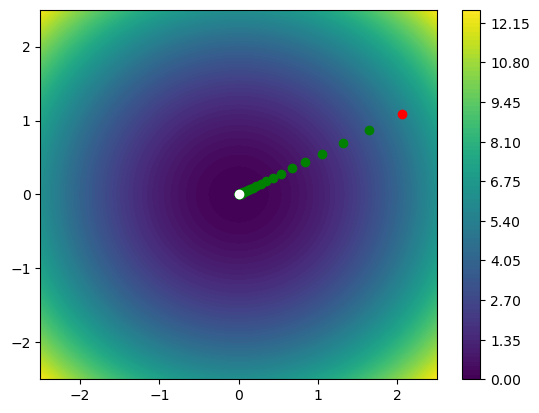

In [94]:
func = lambda x: x[0]**2 + x[1]**2
resolucion = 100
rango = 2.5
gamma = 0.1
tol=1e-12
maxit=1e5

analizar_decenso_gradiente(func, resolucion, rango, gamma, tol, maxit)

### Sin ADAM y con gamma 1
Si la tasa de aprendizaje es muy grande, se pueden producir faltas de convergencia del algoritmo.

El punto final del cálculo del descenso de gradiente es [ 1.95012217 -0.27755922] con valor 3.880015601672952


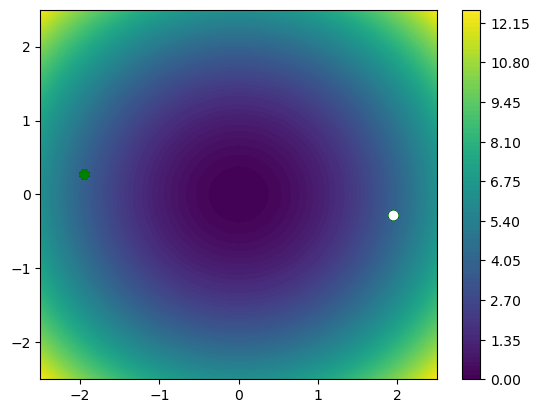

In [104]:
func = lambda x: x[0]**2 + x[1]**2
resolucion = 100
rango = 2.5
gamma = 1
tol=1e-12
maxit=1e5

analizar_decenso_gradiente(func, resolucion, rango, gamma, tol, maxit)

### Con ADAM
Se puede observar como también se llega al punto deseado, pero en este caso la trayectoria que se sigue no es recta.

El punto final del cálculo del descenso de gradiente es [-1.22910468e-07 -1.91011455e-07] con valor 5.1592359265007985e-14


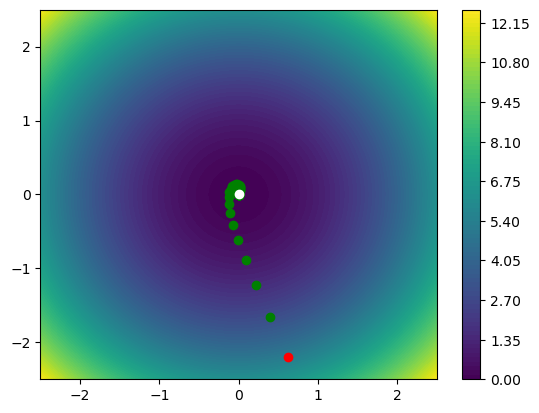

In [107]:
func = lambda x: x[0]**2 + x[1]**2
resolucion = 100
rango = 2.5
gamma = 0.1
tol=1e-12
maxit=1e5

analizar_decenso_gradiente(func, resolucion, rango, gamma, tol, maxit, apply_adam=True)

## Función sin(1/2*x^2 -1/4*y^2 + 3) * cos(2*x + 1 - exp(y))
### Sin ADAM
En este caso, y dada la existencia de diferentes mínimos locales, es más sencillo quedar atrapado en ellos si no se elige un buen valor para la tasa de aprendizaje. En la gráfica siguiente mostramos uno de esos casos. Por análisis de la señal sabemos que el mínimo de la multiplicación de un seno y un coseno es -1. Sin embargo en este caso nos paramos en un punto con valor -0.12.

En función de el punto inicial sí llegamos a un mínimo absoluto.

El punto final del cálculo del descenso de gradiente es [3.70017732 2.95872813] con valor -0.119820618103376


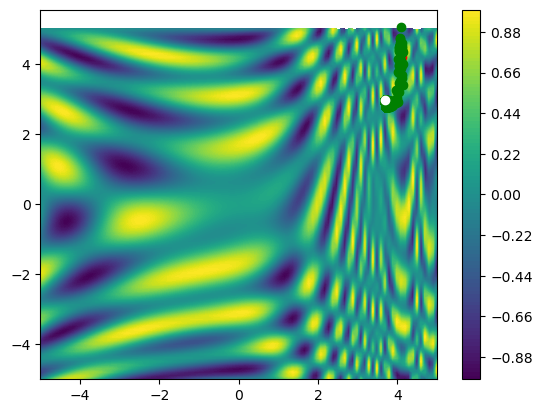

In [97]:
func = lambda x: sympy.sin(0.5*x[0]**2 -0.25*x[1]**2 + 3) * sympy.cos(2*x[0] + 1 - sympy.exp(x[1]))
resolucion = 100
rango = 5
gamma = 0.01
tol=1e-12
maxit=1e5

analizar_decenso_gradiente(func, resolucion, rango, gamma, tol, maxit)

### Con ADAM
Usando ADAM compruebo una mejor convergencia del algoritmo. En ocasiones sigo sin encontrar el mínimo global, pero es lo esperable.

El punto final del cálculo del descenso de gradiente es [2.20178673 1.6870605 ] con valor -0.999999999999988


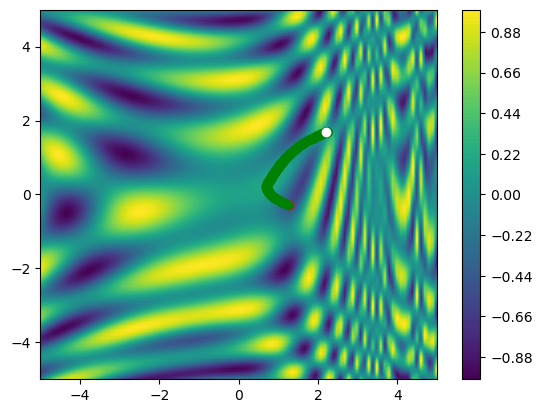

In [112]:
func = lambda x: sympy.sin(0.5*x[0]**2 -0.25*x[1]**2 + 3) * sympy.cos(2*x[0] + 1 - sympy.exp(x[1]))
resolucion = 100
rango = 5
gamma = 0.01
tol=1e-12
maxit=1e5

analizar_decenso_gradiente(func, resolucion, rango, gamma, tol, maxit, apply_adam=True)